# GR5243 Group Project
##### Xingchen Ji, Yuting Wang, Hongyi Xu, and Jiacan Zhou

### Part 1. Data Collection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
eta = pd.read_csv("../Data/RTA.csv")

### Part 2. Data Cleaning and Data Preprocessing

##### (a) Handling Missing Data and Invalid Variables

[Text(0.5, 1.0, 'Histogram of Accident Severity'),
 Text(0.5, 0, 'Accident Severity')]

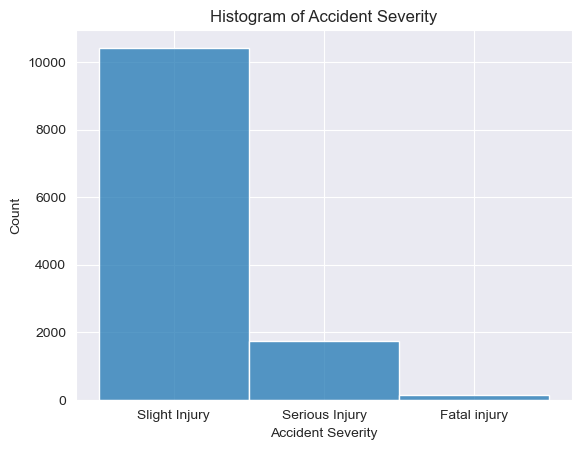

In [3]:
eta["Accident_severity"].value_counts()
sns.histplot(eta["Accident_severity"]).set(title = "Histogram of Accident Severity", xlabel = "Accident Severity")

In [4]:
eta.drop(["Service_year_of_vehicle", "Defect_of_vehicle", "Work_of_casuality", "Fitness_of_casuality"], axis = 1, inplace = True)
eta.drop(["Time", "Weather_conditions", "Casualty_class", "Sex_of_casualty", "Age_band_of_casualty", "Casualty_severity"], axis = 1, inplace = True)

In [5]:
categorical = [col for col in eta.columns]
categorical.remove("Number_of_vehicles_involved")
categorical.remove("Number_of_casualties")
categorical.remove("Accident_severity")
numerical = ["Number_of_vehicles_involved", "Number_of_casualties"]

In [6]:
eta.dropna(subset = categorical, inplace = True)

##### (b) Data Transformation

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
eta_fs = eta.copy()
eta_fs[numerical] = scaler.fit_transform(eta_fs[numerical])
y_cgan = eta_fs["Accident_severity"]
y_cgan = pd.get_dummies(y_cgan, columns = ["Accident_severity"])
y = y_cgan.to_numpy(dtype = np.float32)
X_cgan = pd.get_dummies(eta_fs, columns = categorical)
X_cgan = X_cgan.drop("Accident_severity", axis = 1)
X = X_cgan.to_numpy(dtype = np.float32)

##### (c) Data Augmentation by CGAN

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skopt import gp_minimize
from skopt.space import Real, Integer
from skorch import NeuralNetClassifier

class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim = 1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = torch.cat([x, labels], dim = 1)
        return self.model(x)

def train_cgan(generator, discriminator, train_loader, device, gen_opt, disc_opt, num_epochs, noise_dim):
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        for i, (real_data, labels) in enumerate(train_loader):
            real_data, labels = real_data.to(device), labels.to(device)
            batch_size = real_data.size(0)

            disc_opt.zero_grad()
            real_output = discriminator(real_data, labels.to(device))
            real_loss = criterion(real_output, torch.ones(batch_size, 1, device = device))

            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_data = generator(noise, labels.to(device))
            fake_output = discriminator(fake_data.detach(), labels.to(device))
            fake_loss = criterion(fake_output, torch.zeros(batch_size, 1, device = device))
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            disc_opt.step()

            gen_opt.zero_grad()
            fake_output = discriminator(fake_data, labels)
            g_loss = criterion(fake_output, torch.ones(batch_size, 1, device=device))
            g_loss.backward()
            gen_opt.step()
        print(f"Epoch: {epoch+1}/{num_epochs}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")
    return g_loss.item()

def bayesian_optimization_cgan(train_loader, device, noise_dim, label_dim, output_dim):
    def objective(params):
        num_epochs, gen_hidden_dim, disc_hidden_dim, gen_lr, gen_beta1, disc_lr, disc_beta1 = params

        generator = Generator(noise_dim, label_dim, output_dim, gen_hidden_dim).to(device)
        discriminator = Discriminator(output_dim, label_dim, disc_hidden_dim).to(device)

        gen_optimizer = optim.Adam(generator.parameters(), gen_lr, betas = (gen_beta1, 0.999))
        disc_optimizer = optim.Adam(discriminator.parameters(), lr = disc_lr, betas = (disc_beta1, 0.999))

        gloss = train_cgan(generator, discriminator, train_loader, device, gen_optimizer, disc_optimizer, num_epochs, noise_dim)
        return gloss

    search_space = [
        Integer(30, 100),
        Integer(128, 512),
        Integer(128, 512),
        Real(1e-5, 1, prior="log-uniform"),
        Real(1e-5, 1, prior="log-uniform"),
        Real(0.0, 0.999),
        Real(0.0, 0.999),
    ]

    result = gp_minimize(
        func = objective,
        dimensions = search_space,
        n_calls = 50,
        random_state = 233,
        n_jobs = 12,
        verbose = 3, 
    )
    
    best_params = {
        "num_epochs": result.x[0],
        "gen_hidden_dim": result.x[1],
        "disc_hidden_dim": result.x[2],
        "gen_lr": result.x[3],
        "disc_lr": result.x[4],
        "gen_beta1": result.x[5],
        "disc_beta1": result.x[6],
    }

    return best_params

In [9]:
dataset = TensorDataset(torch.tensor(X, dtype = torch.float32), torch.tensor(y, dtype = torch.float32))
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
label_dim = y_cgan.shape[1]
input_dim = X_cgan.shape[1]
output_dim = X_cgan.shape[1]
best_params = bayesian_optimization_cgan(dataloader, device, noise_dim, label_dim, output_dim)
print(f"Best Parameters: {best_params}")

Iteration No: 1 started. Evaluating function at random point.
Epoch: 1/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 2/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 3/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 4/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 5/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 6/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 7/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 8/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 9/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 10/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 11/64, Generator Loss: 0.0, Discriminator Loss: 100.00000762939453
Epoch: 12/64, Generator Loss: 0.8403362035751343, Discriminator Loss: 100.00000762939453
Epoch: 13/64, Generator Loss: 0.0, Discrimin

##### (d) Feature Selection by AdaBoosting with Decision Stump

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 233)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 100)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

feature_importance = np.mean([tree.feature_importances_ for tree in ada.estimators_], axis = 0)
feature_importance = pd.DataFrame(feature_importance, index = X_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)
aggregated_features = {}
variable_index = categorical + numerical
for feature in variable_index:
    for i in range(len(feature_importance.index)):
        if feature in feature_importance.index[i]:
            if feature in aggregated_features:
                aggregated_features[feature] += feature_importance.iloc[i, 0]
            else:
                aggregated_features[feature] = feature_importance.iloc[i, 0]
        else:
            if feature not in aggregated_features:
                aggregated_features[feature] = 0
aggregated_features = pd.DataFrame.from_dict(aggregated_features, orient = "index", columns = ["importance"]).sort_values("importance", ascending = False)
aggregated_features

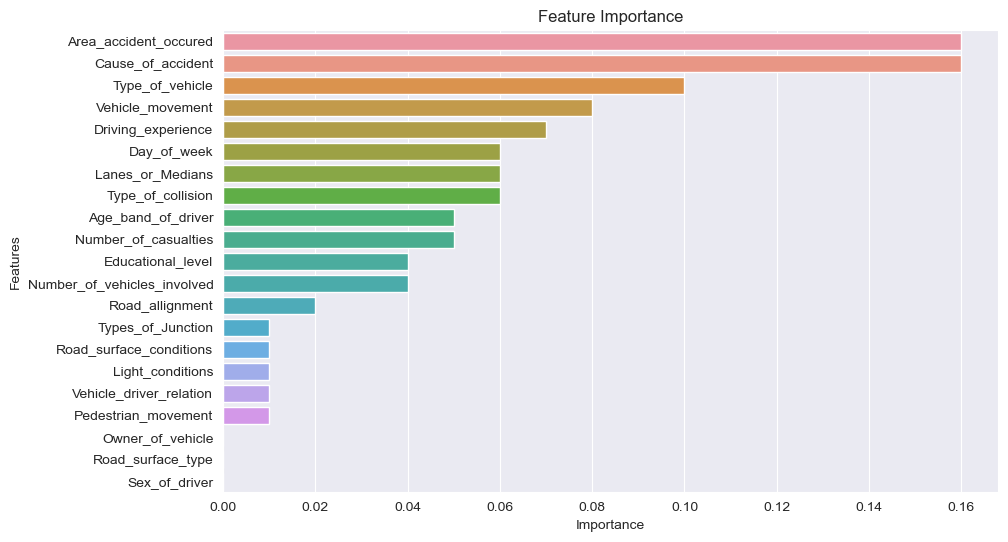

In [8]:
plt.figure(figsize = (10, 6))
sns.barplot(x = aggregated_features["importance"], y = aggregated_features.index).set(title = "Feature Importance", xlabel = "Importance", ylabel = "Features");

In [11]:
ada_feature = aggregated_features.index[:12].tolist()
eta_new = eta[ada_feature]
eta_new.head()

,Area_accident_occured,Cause_of_accident,Type_of_vehicle,Vehicle_movement,Driving_experience,Day_of_week,Lanes_or_Medians,Type_of_collision,Age_band_of_driver,Number_of_casualties,Educational_level,Number_of_vehicles_involved
1,Office areas,Overtaking,Public (> 45 seats),Going straight,Above 10yr,Monday,Undivided Two way,Vehicle with vehicle collision,31-50,2,Junior high school,2
3,Office areas,Changing lane to the right,Public (> 45 seats),Going straight,5-10yr,Sunday,other,Vehicle with vehicle collision,18-30,2,Junior high school,2
7,Residential areas,No priority to vehicle,Automobile,U-Turn,2-5yr,Friday,other,Vehicle with vehicle collision,18-30,1,Junior high school,2
8,Industrial areas,Changing lane to the right,Lorry (41?100Q),Going straight,Above 10yr,Friday,other,Collision with roadside-parked vehicles,18-30,1,Junior high school,2
9,Residential areas,Moving Backward,Automobile,U-Turn,1-2yr,Friday,Undivided Two way,Collision with roadside-parked vehicles,18-30,1,Junior high school,2


In [13]:
categorical_new = [col for col in eta_new.columns]
categorical_new.remove("Number_of_vehicles_involved")
categorical_new.remove("Number_of_casualties")
numerical_new = ["Number_of_vehicles_involved", "Number_of_casualties"]

### Part 3. Explanatory Data Analysis

##### (a) Descriptive Statistics

##### (b) Data Visualization

##### (c) Correlation Analysis

##### (d) Dimensionality Reduction by PCA

##### (e) Cluster Analysis by Hierarchical Clustering

### Part 4. Data Spliting

In [14]:
standard = StandardScaler()
eta_new[numerical_new] = standard.fit_transform(eta_new[numerical_new])
X = pd.get_dummies(eta_new, columns = categorical_new, drop_first = True)
y = y_ada

C:\Users\26447\AppData\Local\Temp\ipykernel_20104\2644754573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eta_new[numerical_new] = standard.fit_transform(eta_new[numerical_new])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state = 233)

### Part 5. Model Selection
#### (a) SVM

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'C': 100, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, degree=1, gamma=1)
Accuracy score:  0.9183325584999226
Classification report:                  precision    recall  f1-score   support

  Fatal injury       0.99      0.99      0.99      2169
Serious Injury       0.98      0.78      0.87      2164
 Slight Injury       0.81      0.99      0.89      2120

      accuracy                           0.92      6453
     macro avg       0.93      0.92      0.92      6453
  weighted avg       0.93      0.92      0.92      6453



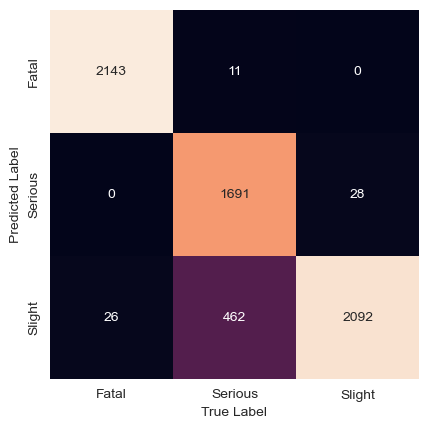

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
param_svc = {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001], "kernel": ["rbf", "linear", "poly", "sigmoid"], "degree": [1, 2, 3, 4]}
svc = GridSearchCV(SVC(), param_svc, refit = True, verbose = 3, n_jobs = 12)
svc.fit(X_train, y_train)
print(svc.best_params_)
print(svc.best_estimator_)
y_pred = svc.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label");

#### (b) Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
param_gbc = {"learning_rate": [0.1, 0.01, 0.001], "n_estimators": [100, 200, 300], "max_depth": [1, 2, 3, 4, 5]}
gbc = GridSearchCV(GradientBoostingClassifier(), param_gbc, refit = True, verbose = 3, n_jobs = 12)
gbc.fit(X_train, y_train)
print(gbc.best_params_)
print(gbc.best_estimator_)
y_pred = gbc.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label");

#### (c) Multilayer Perceptron

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 100, 100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}
MLPClassifier(alpha=0.05, hidden_layer_sizes=(100, 100, 100, 100, 100),
              learning_rate='adaptive', solver='sgd')
Accuracy score:  0.903300790330079
Classification report:                  precision    recall  f1-score   support

  Fatal injury       0.98      0.99      0.99      2169
Serious Injury       0.90      0.82      0.86      2164
 Slight Injury       0.83      0.90      0.87      2120

      accuracy                           0.90      6453
     macro avg       0.90      0.90      0.90      6453
  weighted avg       0.90      0.90      0.90      6453



c:\Users\26447\anaconda3\envs\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


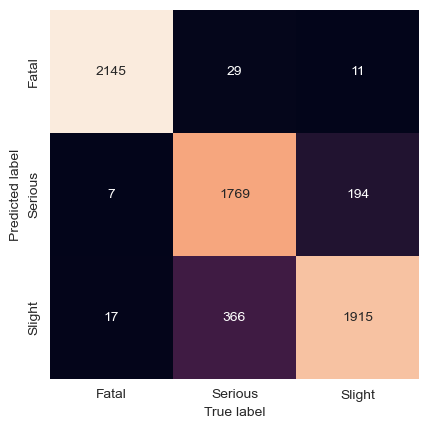

In [21]:
from sklearn.neural_network import MLPClassifier
param_mlp = {"hidden_layer_sizes": [(100, 100, 100), (100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], "activation": ["relu", "logistic"], "solver": ["adam", "sgd"], "alpha": [0.0001, 0.05], "learning_rate": ["constant", "adaptive"]}
mlp = GridSearchCV(MLPClassifier(), param_mlp, refit = True, verbose = 3, n_jobs = 12)
mlp.fit(X_train, y_train)
print(mlp.best_params_)
print(mlp.best_estimator_)
y_pred = mlp.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True label")
plt.ylabel("Predicted label");

#### (d)

### Part 6. Model Evaluation

In [23]:
models = pd.DataFrame({
    "Model": ["Support Vector Machine", "Gradient Boosting", "Multilayer Perceptron"],
    "Accuracy": [accuracy_score(y_test, svc.predict(X_test)), accuracy_score(y_test, gbc.predict(X_test)), accuracy_score(y_test, mlp.predict(X_test))]})
models.sort_values(by = "Accuracy", ascending = False)

,Model,Accuracy
0,Support Vector Machine,0.918333
2,Multi-layer Perceptron,0.903301
1,Random Forest,0.883155


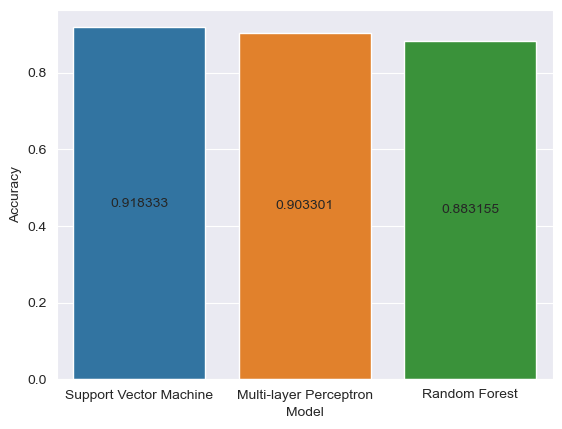

In [24]:
ax = sns.barplot(x = "Model", y = "Accuracy", data = models.sort_values(by = "Accuracy", ascending = False))
for acc in ax.containers:
    ax.bar_label(acc, label_type = "center");